Here's the scenario summary:


{'LTE': 4,
 'dataframe':             time  emissions
 0    1750.000000   0.013363
 1    1750.450450   0.013514
 2    1750.900901   0.013667
 3    1751.351351   0.013822
 4    1751.801802   0.013978
 ..           ...        ...
 995  2198.198198   4.000000
 996  2198.648649   4.000000
 997  2199.099099   4.000000
 998  2199.549550   4.000000
 999  2200.000000   4.000000
 
 [1000 rows x 2 columns],
 'delta_t_trans': 20,
 'emission units': 'GtC/year',
 'eps_0': 11.3,
 'k': 0.025,
 'nsteps': 1000,
 't_0': 2020,
 't_peak': 2040,
 't_start': 1750,
 't_stop': 2200}

<IPython.core.display.Javascript object>


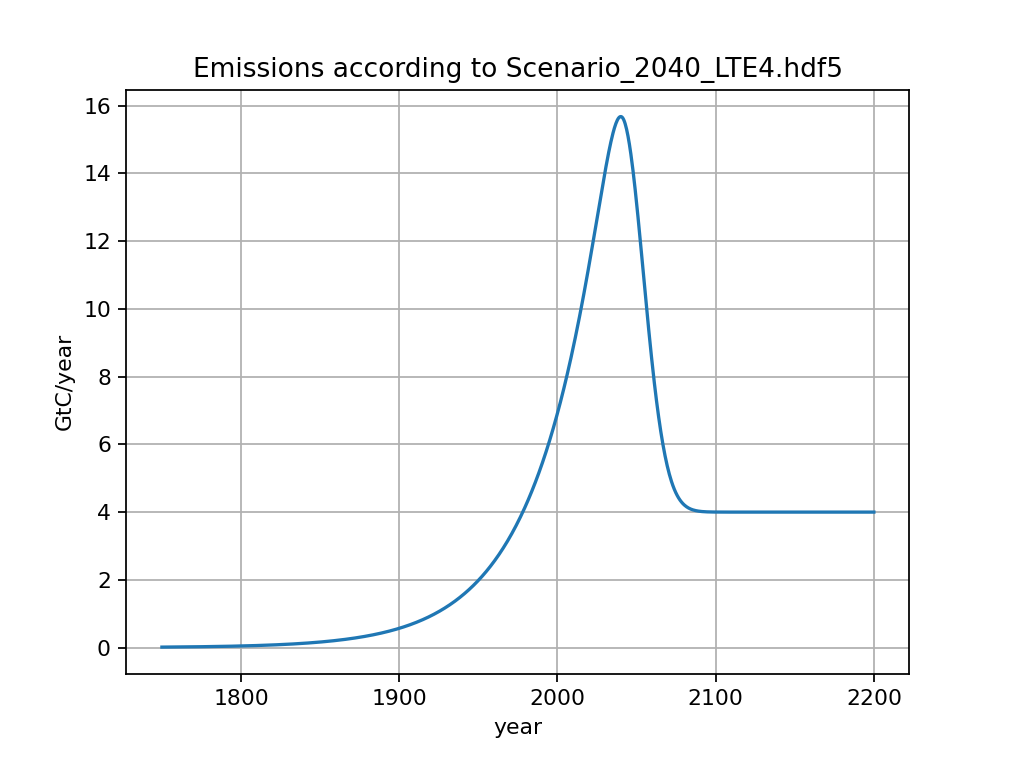

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys; sys.path.append('/home'); import Conn350Lib as CL
import random
from copy import copy as makeacopy

%matplotlib notebook

# Reading in the emissions scenario file
filename = 'Scenario_2040_LTE4.hdf5'
time, eps = CL.GetMyScenario(filename,reportflag=True,plotflag=True)

# Start with an empty dictionary
ClimateParams = {}

# Preindustrial climate values
ClimateParams['preindust_C_atm'] = 615
ClimateParams['preindust_C_ocean'] = 350
ClimateParams['preindust_albedo'] = 0.3
ClimateParams['preindust_pH'] = 8.2

# Parameter for the basic sensitivity of the climate to increasing CO2
ClimateParams['climate_sensitivity'] = 3/ClimateParams['preindust_C_atm'] # IPCC: 3 degrees for doubled CO2

# Carbon flux constants
ClimateParams['k_la'] = 120
ClimateParams['k_al0'] = 113
ClimateParams['k_al1'] = 0.0114
ClimateParams['k_oa'] = 0.2
ClimateParams['k_ao'] = 0.114

# Parameter for the ocean degassing flux feedback
ClimateParams['DC'] = 0.034 # Pretty well known from physical chemistry

# Parameters for albedo feedback
ClimateParams['albedo_sensitivity'] = -100 # Based on our radiative balance sensitivity analysis
ClimateParams['albedo_transition_temperature'] = 2.5 # T at which significant albedo reduction kicks in (a guess)
ClimateParams['albedo_transition_interval'] = 1 # Temperature range over which albedo reduction kicks in (a guess)
ClimateParams['max_albedo_change_rate'] = 0.0006 # Amount albedo can change in a year (based on measurements)
ClimateParams['fractional_albedo_floor'] = 0.9 # Maximum of 10% reduction in albedo (a guess)

# Parameters for the atmosphere->land flux feedback
ClimateParams['F_al_transitionT'] = 2.0 # T anomaly at which photosynthesis will become impaired (a guess)
ClimateParams['F_al_transitionTinterval'] = 1 # Temperature range over which photosynthesis impairment kicks in (guess)
ClimateParams['fractional_F_al_floor'] = 0.9 # Maximum of 10% reduction in F_al (a guess)

# Create a starting state -- the default is a preindustrial state
PreindustClimateState = CL.CreateClimateState(ClimateParams)

# Specify the starting year
PreindustClimateState['time'] = eps[0]

def PropagateClimateState(previousClimateState, ClimateParams, dtime=1, F_ha=0, feedbacklevel=0):
    """Propagates the state of the climate with feedbacks"""
    """Default anthropogenic carbon flux is zero"""
    """Default time step is 1 year"""
    """Returns a new climate state"""

    # Extract concentrations from the previous climate state
    C_atm = previousClimateState['C_atm']
    C_ocean = previousClimateState['C_ocean']
    
    # The no-feedback option
    if feedbacklevel == 0:
        
        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, 0, ClimateParams) # We're assuming T_anomaly=0 here
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(0, C_atm, ClimateParams) # We're assuming T_anomaly=0 here

        # Get new concentrations of carbon that depend on the fluxes
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
        C_ocean += (F_ao - F_oa)*dtime

        # Diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)
        ifblock = 'complete'

    # Level 1 feedback: Incorporating the effect of temperature anomaly on the ocean->atmosphere flux
    elif feedbacklevel == 1:
        
        # your code here
        
        # Diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)
        
        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams) # Incorporate T_anomaly into F_oa
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(0, C_atm, ClimateParams) # We're assuming T_anomaly=0 here

        # Get new concentrations of carbon that depend on the fluxes
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
        C_ocean += (F_ao - F_oa)*dtime

        ifblock = 'complete'
        

    # Level 2 feedbacks: Adding to Level 1 the effect of temperature anomaly on the atmosphere->land flux
    elif feedbacklevel == 2:
        
        # Diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)
        
        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams) # Incorporate T_anomaly into F_oa
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(T_anomaly, C_atm, ClimateParams) # Incorporate T_anomaly into F_al

        # Get new concentrations of carbon that depend on the fluxes
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha)*dtime
        C_ocean += (F_ao - F_oa)*dtime

        ifblock = 'complete'

    # Level 3 feedbacks: Adding to Level 2 the effect of temperature anomaly on albedo
    elif feedbacklevel == 3:
        
        # your code here
        
        # Diagnostics
        pH = CL.Diagnose_OceanSurfacepH(C_atm, ClimateParams)
        T_anomaly = CL.Diagnose_T_anomaly(C_atm, ClimateParams)
        
        # Use albedo_delta_T = AS * (a_current - a_preindust) to update albedo with T_anomaly.
        albedo = CL.Diagnose_albedo(T_anomaly, ClimateParams)
        AS = ClimateParams['albedo_sensitivity']
        albedo_preindust = ClimateParams['preindust_albedo']
        albedo_delta_T = AS * (albedo - albedo_preindust)
        T_anomaly += albedo_delta_T
        T_C = CL.Diagnose_actual_temperature(T_anomaly)
        T_F = CL.Diagnose_degreesF(T_C)
        
        # Get new fluxes -- assuming zeros for temperature anomaly
        F_oa = CL.Diagnose_F_oa(C_ocean, T_anomaly, ClimateParams) # Incorporate T_anomaly into F_oa
        F_ao = CL.Diagnose_F_ao(C_atm, ClimateParams)
        F_la = CL.Diagnose_F_la(ClimateParams)
        F_al = CL.Diagnose_F_al(T_anomaly, C_atm, ClimateParams) # Incorporate T_anomaly into F_al

        # Get new concentrations of carbon that depend on the fluxes
        
        C_atm += (F_la + F_oa - F_ao - F_al + F_ha) * dtime 
        C_atm_rand = C_atm * (random.uniform(-0.04, 0.04) + 1)
        C_ocean += (F_ao - F_oa)*dtime

        ifblock = 'complete'
        
    else:
        print('That feedback level has not been implemented')
        return
    
    
    # Create a new climate state with these updates
    ClimateState = makeacopy(previousClimateState)
    ClimateState['C_atm'] = C_atm
    ClimateState['C_ocean'] = C_ocean
    ClimateState['F_oa'] = F_oa
    ClimateState['F_ao'] = F_ao
    ClimateState['F_la'] = F_la
    ClimateState['F_al'] = F_al
    ClimateState['time'] += dtime
    ClimateState['F_ha'] = F_ha
    ClimateState['T_anomaly'] = T_anomaly
    ClimateState['pH'] = pH
    ClimateState['T_C'] = T_C
    ClimateState['T_F'] = T_F
    ClimateState['albedo'] = albedo
    ClimateState['C_atm_rand'] = C_atm_rand

    # Return the new climate state
    return ClimateState

# Initialize our list of climate states
ClimateState_list = []

# Make the starting state the preindustrial
ClimateState = CL.CreateClimateState(ClimateParams)

# Add some times
dt = time[1]-time[0]
ClimateState['time'] = time[0]-dt # This sets the starting year as one step prior to the start 

# Set the feedback level
fbl = 3

# Loop over all the times in the scheduled flow
for i in range(len(time)):

    # Propagate
    ClimateState = PropagateClimateState(ClimateState,ClimateParams,dtime=dt,F_ha=eps[i],feedbacklevel=fbl)
    
    # Add to our list of climate states
    ClimateState_list.append(ClimateState)
    


<IPython.core.display.Javascript object>


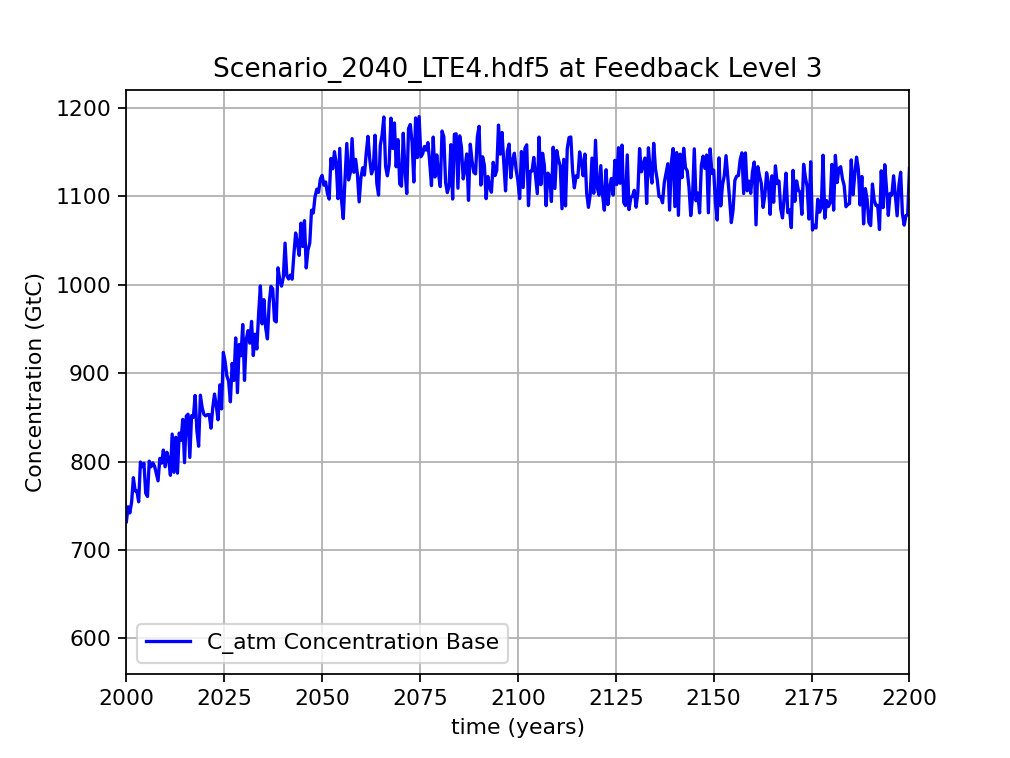

In [6]:
# Extracting the times from ClimateState_list
time = CL.CollectClimateTimeSeries(ClimateState_list,'time')
C_atm_rand = CL.CollectClimateTimeSeries(ClimateState_list,'C_atm_rand')


plot_title = filename + ' at Feedback Level ' + str(fbl) # This will be a title over plots
lnw = 3 # This will be the linewidth for plotting

time = CL.CollectClimateTimeSeries(ClimateState_list,'time')
plt.figure()
plot_title = filename + ' at Feedback Level ' + str(fbl) # This will be a title over plots
lnw = 3 # This will be the linewidth for plotting
plt.title(plot_title)
plt.plot(time, C_atm_rand, '-b', label = 'C_atm Concentration Base')
plt.xlim(2000, 2200)

# #plt.figure()
# plt.plot(time, C_atm_rand1, '-r', label = 'C_atm Concentration + Var1')
# plt.xlim(2000, 2200)

# #plt.figure()
# plt.plot(time, C_atm_rand2, '-g', label = 'C_atm Concentration + Var2')
# plt.xlim(2000, 2200)

# plt.figure()
# plt.plot(time, C_atm_base, '-b', label = 'C_atm Concentration Base')
# plt.plot(time, C_atm_rand, '-y', label = 'C_atm Concentration + Var3')
# plt.xlim(2000, 2200)

plt.grid(True)
plt.xlabel('time (years)')
plt.ylabel("Concentration (GtC)")
leg = plt.legend()